In [1]:
import sys
import affine
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
from skimage.filters import threshold_otsu
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.features import shapes
from scipy.ndimage import gaussian_filter
from shapely.geometry import shape, Point, LineString
from shapely.ops import nearest_points


def RMSE(data):
    return np.sqrt((data ** 2).mean())


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def points_along_line(line_gdf, dist=10):    

    out = [] 
    
    # create points every 30 meters along the line
    for i, distance in enumerate(range(0, int(line_gdf.length), dist)):
        point = line_gdf.interpolate(distance)
        out.append(point[0])
        
    subpixel_points = gpd.GeoDataFrame(geometry=out, crs=line_gdf.crs)
    return subpixel_points


def dist_stats(ds, ref_gdf, subpixel_gdf, wholepixel_gdf, dist=10, clip_max=False):

    # Compute differences from points along sub-pixel waterline to reference waterline
    ref_union = ref_gdf.geometry.unary_union
    subpixel_points = points_along_line(subpixel_gdf, dist=dist)
    subpixel_points['dist_val'] = subpixel_points.apply(lambda x: x.geometry.distance(ref_union), axis=1)

    # Set directionality based on land or water line of reference line
    change_sign = np.where(ds.land_water.astype(float)
                           .interp(x=xr.DataArray(subpixel_points.geometry.x, dims='z'), 
                                   y=xr.DataArray(subpixel_points.geometry.y, dims='z')) >= 0.5, 1, -1)
    subpixel_points['dist_val'] = subpixel_points.dist_val * change_sign

    # Compute differences from points along whole-pixel waterline to reference waterline
    wholepixel_points = points_along_line(gpd.GeoSeries(wholepixel_gdf.unary_union), dist=dist)
    wholepixel_points['dist_val'] = wholepixel_points.apply(lambda x: x.geometry.distance(ref_union), axis=1)
    
    # If clip_max=True, remove all points located on the very edge of the study area.
    # This removes the outside of the polygonised study area from being included in the waterline
    if clip_max:
        wholepixel_points = wholepixel_points[(wholepixel_points.geometry.x != 
                                               wholepixel_points.geometry.x.max()) &
                                              (wholepixel_points.geometry.y != 
                                               wholepixel_points.geometry.y.min()) &
                                              (wholepixel_points.geometry.x != 
                                               wholepixel_points.geometry.x.min()) &
                                              (wholepixel_points.geometry.y != 
                                               wholepixel_points.geometry.y.max())].copy()

    # Set directionality based on land or water line of reference line
    change_sign = np.where(ds.land_water.astype(float)
                           .interp(x=xr.DataArray(wholepixel_points.geometry.x, dims='z'),
                                   y=xr.DataArray(wholepixel_points.geometry.y, dims='z')) >= 0.5, 1, -1)
    wholepixel_points['dist_val'] = wholepixel_points.dist_val * change_sign
    
    # Return dataframes of points and distances for sub-pixel and whole-pixel waterlines
    return subpixel_points, wholepixel_points


def simulated_waterlines(ds, agg_factor = 30, thresh_subpixel = 0, thresh_thresholded = 0, water_index='NDWI', outdir=''):
    
    # Aggregate data to new resolution and update transform
    ds_agg = ds.coarsen(x=agg_factor, y=agg_factor, boundary='trim').mean()
    ds_agg.attrs['transform'] = ds.transform * affine.Affine.scale(agg_factor)
    ds_agg.attrs['crs'] = ds.crs

    # Compute water index on aggregate data
    if water_index == 'NDWI':
        ds_agg['water_index'] = (ds_agg.green - ds_agg.nir) / (ds_agg.green + ds_agg.nir)
    if water_index == 'NDWI_wv2':
        ds_agg['water_index'] = (ds_agg.BAND_G - ds_agg.BAND_N) / (ds_agg.BAND_G + ds_agg.BAND_N)
    elif water_index == 'MNDWI':
        ds_agg['water_index'] = (ds_agg.green - ds_agg.swir1) / (ds_agg.green + ds_agg.swir1)
    elif water_index == 'AWEI_ns':
        ds_agg['water_index'] = ((4 * (ds_agg.green * 0.0001 - ds_agg.swir1 * 0.0001) - 
                                           (0.25 * ds_agg.nir * 0.0001 + 2.75 * ds_agg.swir1 * 0.0001)))
    elif water_index == 'AWEI_sh':
        ds_agg['water_index'] = (ds_agg.blue * 0.0001 + 2.5 * ds_agg.green * 0.0001 - 1.5 * 
                                          (ds_agg.nir * 0.0001 + ds_agg.swir1 * 0.0001) - 0.25 * ds_agg.swir2 * 0.0001)
        
    # Extract shoreline along true land-water validation boundary
    ref_gdf = SpatialTools.contour_extract(z_values=[0.5],
                                           ds_array=ds.land_water,
                                           ds_crs=ds.crs, 
                                           ds_affine=ds.transform, 
                                           output_shp=f'{outdir}reference.shp',
                                           min_vertices=2,
                                           verbose=False)

    # Extract subpixel shoreline along aggregated dataset based on water index
    subpixel_gdf = SpatialTools.contour_extract(z_values=[thresh_subpixel],
                                                ds_array=ds_agg.water_index,
                                                ds_crs=ds.crs,
                                                ds_affine=ds_agg.transform,
                                                output_shp=f'{outdir}subpixel_agg{agg_factor}.shp',
                                                min_vertices=2,
                                                verbose=False)

    # Threshold to water index value
    ds_bool = (ds_agg.water_index > thresh_thresholded)

    # Polygonise and filter to keep only values = 1
    geoms = list(shapes(ds_bool.values.astype(np.int16), transform=ds_agg.transform))
    geoms = [(a, b) for (a, b) in geoms if b == 1.0]
    geoms_shape = [shape(a) for (a, b) in geoms]
    data = [b for (a, b) in geoms]

    # Covert to a geodataframe of blocky waterlines
    wholepixel_gdf = gpd.GeoDataFrame(data={'value': data}, geometry = geoms_shape)
    wholepixel_gdf['geometry'] =  [LineString(i.coords) for i in wholepixel_gdf.geometry.exterior]
    wholepixel_gdf.crs = ds.crs
    wholepixel_gdf.to_file(f'{outdir}wholepixel_agg{agg_factor}.shp')
    
    # Return waterlines
    return ref_gdf, subpixel_gdf, wholepixel_gdf, ds_agg


def synthetic_scenarios(thresh_array, scenarios_df, spectra_scenarios, dist=10):

    output_dist_list = []

    for i, (spectra, water_index, resolution, thresh_subpixel, thresh_thresholded) in scenarios_df.iterrows():

        print('\rSpectra:', spectra, 'Index:', water_index, 'Resolution:', resolution, 
              'Threshold subpixel:', np.round(thresh_subpixel, 2), 'Threshold threshholded:', np.round(thresh_thresholded, 2), end='')

        try:    

            ############################
            # Generate spectral xarray #
            ############################

            # Create 3D array with water and land spectra
            water_3d = np.broadcast_to(np.array(spectra_scenarios[spectra]['water']), (size_x, size, 6)).T
            land_3d = np.broadcast_to(np.array(spectra_scenarios[spectra]['land']), (size_x, size, 6)).T
            spectra_array = np.where(thresh_array, water_3d, land_3d)

            # Add validation land, water distribution as extra band
            spectra_array = np.concatenate([~thresh_array[None,...], spectra_array])

            # Convert to xarray format and rename bands
            synthetic_array = xr.DataArray(spectra_array, 
                                           dims=['variable', 'y', 'x'], 
                                           coords={'x': np.arange(0, 1000, 1), 
                                                   'y': np.arange(0, -500, -1)})
            synthetic_ds = synthetic_array.to_dataset(dim='variable').rename({0: 'land_water', 1: 'blue', 2: 'green', 3: 'red', 
                                                                              4: 'nir', 5: 'swir1', 6: 'swir2'})  

            # Set affine and CRS
            synthetic_ds.attrs['transform'] = affine.Affine(1, 0, 0, 0, -1, 0)
            synthetic_ds.attrs['crs'] = 'EPSG:4326'        

            ####################
            # Model shorelines #
            ####################

            # Generate simulated shoreline based on input threshold and aggregation factor
            output_waterlines = simulated_waterlines(synthetic_ds, 
                                                     agg_factor = resolution, 
                                                     thresh_subpixel = thresh_subpixel, 
                                                     thresh_thresholded = thresh_thresholded, 
                                                     water_index = water_index)
            val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse = output_waterlines

            # Compute OTSU on NDWI layer
            otsu = threshold_otsu(synthetic_coarse.water_index.values)
            
            # Compute distances
            subpixel_points, wholepixel_points = dist_stats(ds=synthetic_ds, 
                                                            ref_gdf=val_shoreline_gdf, 
                                                            subpixel_gdf=subpixel_shoreline_gdf, 
                                                            wholepixel_gdf=blocky_shoreline_gdf, 
                                                            dist=dist,
                                                            clip_max=True)   

            # Append to list
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_subpixel, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Subpixel', 
                                                  'Error (m)': subpixel_points['dist_val'], 'otsu': otsu}))
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_thresholded, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Thresholded', 
                                                  'Error (m)': wholepixel_points['dist_val'], 'otsu': otsu}))                                   

        except:
            pass

    # Combine results into a single dataframe
    accuracy_results = pd.concat(output_dist_list)
    
    # Return dataframe
    return accuracy_results


# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('/g/data/r78/rt1527/dea-notebooks/10_Scripts')
import SpatialTools, DEADataHandling

%load_ext autoreload
%autoreload 2

## Example 2: smooth beach curve

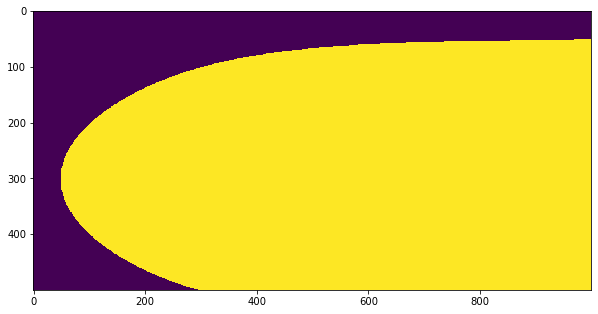

In [2]:
size, size_x = 500, 1000
empty_array = np.zeros(shape=(size, size_x))

x = np.linspace(0, size_x, 1000000)
y = (size - 250) *np.tanh(0.003 * x) ** 0.5

x2 = np.linspace(0, size_x, 1000000)
y2 = (-size + 250) *np.tanh(0.003 * x) ** 0.5

x = np.concatenate([x + 50, x2 + 50])
y = np.concatenate([y + 200, y2 + 200])

empty_array[-y.astype(int).clip(0, size - 1), 
             x.astype(int).clip(10, size_x - 1)] = 100


fig, ax = plt.subplots(figsize=(10, 10))
thresh_array = np.maximum.accumulate(empty_array.astype(int),1)
thresh_array = thresh_array==np.unique(thresh_array)[1]
thresh_array[0,:] = 0

# beach_curve = thresh_array
ax.imshow(thresh_array)


## Spectra

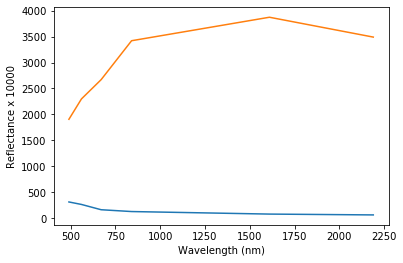

In [149]:
# water_spectra = [255, 191, 101, 87, 52, 59]  # deep blue water (Stockton Beach)
# water_spectra = [709, 1028, 544, 226, 205, 180]  # shallow blue water (Stockton Beach)
water_spectra = [1952, 2113, 1110, 405, 340, 282]  # shallow/sandy bottom tropical water (GBR)
# water_spectra = [929, 1226, 1537, 1401, 248, 175]  # highly turbid water (cambridge gulf)
# water_spectra = [805, 1226, 1537, 777, 86, 68]  # mod turbid water (cambridge gulf)


# land_spectra = [2370, 3326, 4165, 4899, 6259, 5992]  # bright yellow sand, dry (Stockton Beach)
# land_spectra = [1084, 1677, 2155, 2544, 2679, 1889]  # bright yellow sand, wet (Stockton Beach)
# land_spectra = [604, 888, 1280, 1633, 1628, 1372]  # exposed cliff (Stockton Beach)
land_spectra = [670, 857, 910, 1107, 1463, 1048]  # tidal mudflat, dry (Darwin)
# land_spectra = [490, 639, 670, 756, 108, 69]  # tidal mudflat, wet (Darwin)
# land_spectra = [417, 528,  345, 2061, 712, 304]  # mangrove vegetation (Darwin)


water_spectra = [310, 262, 160, 125, 76, 60]  # deep water off Sydney
land_spectra = [1905, 2298, 2670, 3421, 3874, 3491]  # artificial (Sydney)


#                      'mangrove_vegetation': {'water': [766, 950, 752, 258, 148, 122], 
#                                              'land': [356, 459, 336, 1848, 598, 316]

# water_spectra = [310, 262, 486, 220, 76, 60]  
# land_spectra = [1905, 2298, 616, 3305, 3874, 3491] 

# water_spectra = [939,1330,1444,944,35,21]  # tidal mudflat 
# land_spectra = [733,965,1043,1088,220,126]  # tidal mudflat 


# water_spectra = [766, 950, 752, 258, 148, 122]
# land_spectra = [356, 459, 336, 1848, 598, 316]




# synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.swir1) / (synthetic_ds.green + synthetic_ds.swir1)

plt.plot([490, 560, 670, 840, 1610, 2190], water_spectra, '-')
plt.plot([490, 560, 670, 840, 1610, 2190], land_spectra, '-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance x 10000');


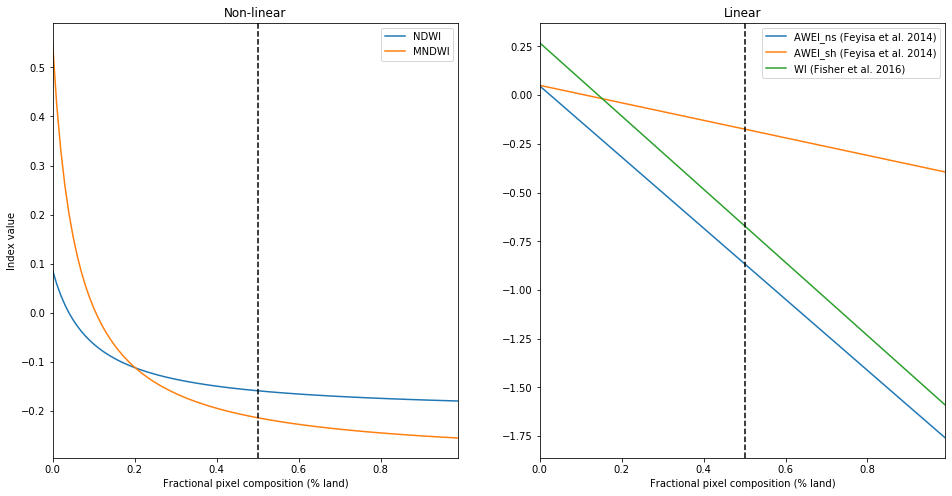

In [144]:
out_perc_land = []
out_ndwi = []
out_mndwi = []
out_awei_ns = []
out_awei_sh = []
out_wi = []

for perc_land in np.arange(0, 1.0, 0.01):
    
    mean_blue = np.mean(perc_land * land_spectra[0] + (1.0 - perc_land) * water_spectra[0])
    mean_green = np.mean(perc_land * land_spectra[1] + (1.0 - perc_land) * water_spectra[1])
    mean_red = np.mean(perc_land * land_spectra[2] + (1.0 - perc_land) * water_spectra[2])
    mean_nir = np.mean(perc_land * land_spectra[3] + (1.0 - perc_land) * water_spectra[3])
    mean_swir1 = np.mean(perc_land * land_spectra[4] + (1.0 - perc_land) * water_spectra[4])
    mean_swir2 = np.mean(perc_land * land_spectra[5] + (1.0 - perc_land) * water_spectra[5])        
    
    awei_ns = (4 * (mean_green * 0.0001 - mean_swir1 * 0.0001) - (0.25 * mean_nir * 0.0001 + 2.75 * mean_swir1 * 0.0001))
    awei_sh = mean_blue * 0.0001 + 2.5 * mean_green * 0.0001 - 1.5 * (mean_nir * 0.0001 + mean_swir1 * 0.0001) - 0.25 * mean_swir2 * 0.0001
    ndwi = (mean_green - mean_nir) / (mean_green + mean_nir)
    mndwi = (mean_green - mean_swir1) / (mean_green + mean_swir1)
    wi = (1.7204 + (171 * mean_green * 0.0001) + (3 * mean_red * 0.0001) - (70 * mean_nir * 0.0001) - (45 * mean_swir1 * 0.0001) - (71 * mean_swir2 * 0.0001))/15
    
    out_perc_land.append(perc_land) 
    out_ndwi.append(ndwi) 
    out_mndwi.append(mndwi)
    out_awei_ns.append(awei_ns)
    out_awei_sh.append(awei_sh)
    out_wi.append(wi)
    
out_indices = pd.DataFrame({'Fractional pixel composition (% land)': out_perc_land, 
                            'NDWI': out_ndwi, 
                            'MNDWI': out_mndwi, 
                            'AWEI_ns (Feyisa et al. 2014)': out_awei_ns, 
                            'AWEI_sh (Feyisa et al. 2014)': out_awei_sh, 
                            'WI (Fisher et al. 2016)': out_wi
                           })

fig, axes = plt.subplots(1, 2, figsize = (16, 8))
out_indices.plot(x='Fractional pixel composition (% land)', y = 'NDWI', ax=axes[0])
out_indices.plot(x='Fractional pixel composition (% land)', y = 'MNDWI', ax=axes[0])     
out_indices.plot(x='Fractional pixel composition (% land)', y = 'AWEI_ns (Feyisa et al. 2014)', ax=axes[1])     
out_indices.plot(x='Fractional pixel composition (% land)', y = 'AWEI_sh (Feyisa et al. 2014)', ax=axes[1])    
out_indices.plot(x='Fractional pixel composition (% land)', y = 'WI (Fisher et al. 2016)', ax=axes[1])  
axes[0].axvline(0.5, color='black', linestyle='--')
axes[1].axvline(0.5, color='black', linestyle='--')
axes[0].set_title('Non-linear')
axes[1].set_title('Linear')
axes[0].set_ylabel("Index value");


NDWI


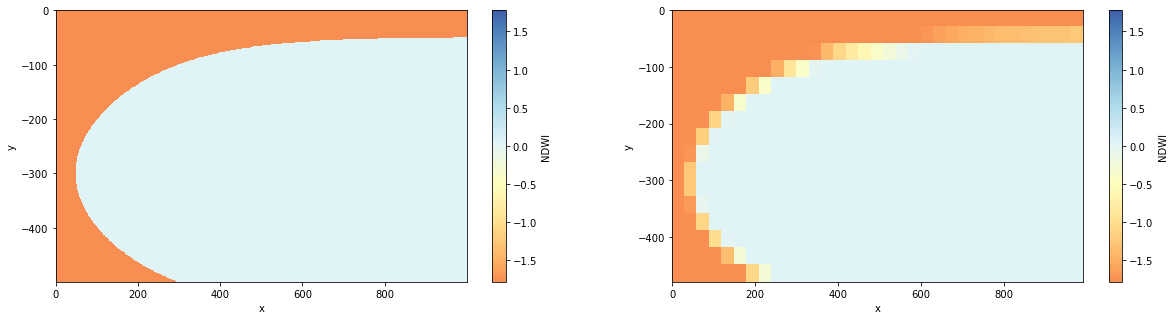

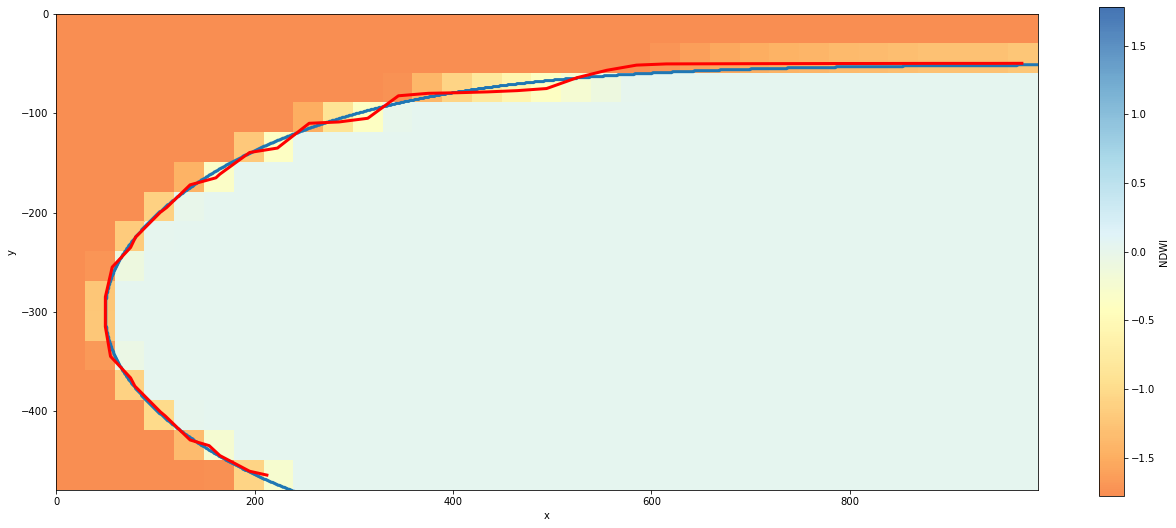

In [153]:
# Create 3D array with water and land spectra
water_3d = np.broadcast_to(np.array(water_spectra), (size_x, size, 6)).T
land_3d = np.broadcast_to(np.array(land_spectra), (size_x, size, 6)).T
spectra_array = np.where(thresh_array, water_3d, land_3d)

# Add validation land, water distribution as extra band
spectra_array = np.concatenate([~thresh_array[None,...], spectra_array])

# Convert to xarray format and rename bands
synthetic_array = xr.DataArray(spectra_array, dims=['variable', 'y', 'x'], coords={'x': np.arange(0, 1000, 1),
                                                                                   'y': np.arange(0, -500, -1)})
synthetic_ds = synthetic_array.to_dataset(dim='variable').rename({0: 'land_water', 1: 'blue', 2: 'green', 3: 'red', 
                                                                  4: 'nir', 5: 'swir1', 6: 'swir2'})


# Compute NDWI on validation dataset
# synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.nir) / (synthetic_ds.green + synthetic_ds.nir)   
synthetic_ds['NDWI'] = (4 * (synthetic_ds.green * 0.0001 - synthetic_ds.swir1 * 0.0001) - (0.25 * synthetic_ds.nir * 0.0001 + 2.75 * synthetic_ds.swir1 * 0.0001))
synthetic_ds['land_water'] = synthetic_ds['NDWI'] > 0

# Set affine and CRS
synthetic_ds.attrs['transform'] = affine.Affine(1, 0, 0, 0, -1, 0)
synthetic_ds.attrs['crs'] = 'EPSG:4326'   

# Extract contours
val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse = simulated_waterlines(synthetic_ds, 
                                                                                                         agg_factor = 30, 
                                                                                                         thresh_subpixel = -0.1,
                                                                                                         thresh_thresholded = -0.1,
                                                                                                         water_index='NDWI')

# Plot validation and aggregated landscapes
fig, ax = plt.subplots(1, 2, figsize=(20.25, 5))
synthetic_ds.NDWI.plot(ax=ax[0], cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.93))
synthetic_coarse.NDWI.plot(ax=ax[1], cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.93))

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(22, 9))
synthetic_coarse.NDWI.plot(ax=ax, cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.90))
val_shoreline_gdf.plot(ax=ax, linewidth=3)
subpixel_shoreline_gdf.plot(ax=ax, color='red', linewidth=3)
blocky_shoreline_gdf.plot(ax=ax, color='black', linewidth=3)


## Analyse by threshold

In [63]:
index_scenarios = ['NDWI', 'MNDWI', 'AWEI_ns']  
thresh_subpixel_scenarios = np.linspace(-1.5, 1.5, 61)
resolution_scenarios = [30]

spectra_scenarios = {          
                     'sandy_beach': {'water': [324.739834,370.696680,170.097925,115.892946,79.772614,68.107054], 
                                     'land': [2166.149770,3372.139880,4209.666549,5050.274461,6109.723419,5735.054045]},    
                     
                     'artificial_shoreline': {'water': [319.136752,270.229345,160.541311,119.081197 ,68.351852,52.182336], 
                                              'land': [1547.503472,1827.168403,	2058.354167 ,2381.638889 ,2422.319444,2144.378472]},   
                                              # 16-day Landsat 8, 06/12/2015, 33.96768°S, 151.19934°E
    
                     'rocky_cliff': {'water': [493.391026, 372.833333, 164.038462, 134.038462, 113.250000, 92.891026], 
                                     'land': [788.339744, 1031.160256, 1276.474359, 2262.615385, 2643.634615 ,1910.634615]},
                     
                     'tidal_mudflat': {'water': [610.764124,708.714689,476.005650,144.207627,46.769774,30.258475], 
                                       'land': [567.228610,739.172460,777.069519,815.175134 ,228.878342,111.766043]},   
                                       # 16-day Landsat 8, 02/08/2016, 12.66255°S, 130.59904°E
    
                     'mangrove_vegetation': {'water': [999.401282 ,1262.644872,743.150641,	103.957692,22.222436,15.263462], 
                                             'land': [213.647059,348.484429 ,217.429931 ,2448.098616, 560.447232 ,224.417820]},

}


# Create dataframe of all scenarios
all_combinations = itertools.product(spectra_scenarios, index_scenarios, 
                                     resolution_scenarios, thresh_subpixel_scenarios)
scenarios_df = pd.DataFrame(all_combinations, columns=['spectra', 'water_index', 
                                                       'resolution', 'thresh_subpixel'])

# Add new column duplicating subpixel threshold for threshholded analysis
scenarios_df['thresh_thresholded'] = scenarios_df.thresh_subpixel


In [69]:
# Analyse scenarios   
accuracy_results = synthetic_scenarios(thresh_array, scenarios_df, spectra_scenarios, dist=10)   
accuracy_results.head()


Spectra: mangrove_vegetation Index: AWEI_ns Resolution: 30 Threshold subpixel: 1.5 Threshold threshholded: 1.5

,spectra,thresh,resolution,water_index,type,Error (m),otsu
0,sandy_beach,-0.15,30,NDWI,Subpixel,0.906654,0.155143
1,sandy_beach,-0.15,30,NDWI,Subpixel,2.812417,0.155143
2,sandy_beach,-0.15,30,NDWI,Subpixel,5.124441,0.155143
3,sandy_beach,-0.15,30,NDWI,Subpixel,7.279104,0.155143
4,sandy_beach,-0.15,30,NDWI,Subpixel,7.988823,0.155143


### Plot results by threshold

Text(0, 4.45, 'No valid\nwaterline\nextracted\n')

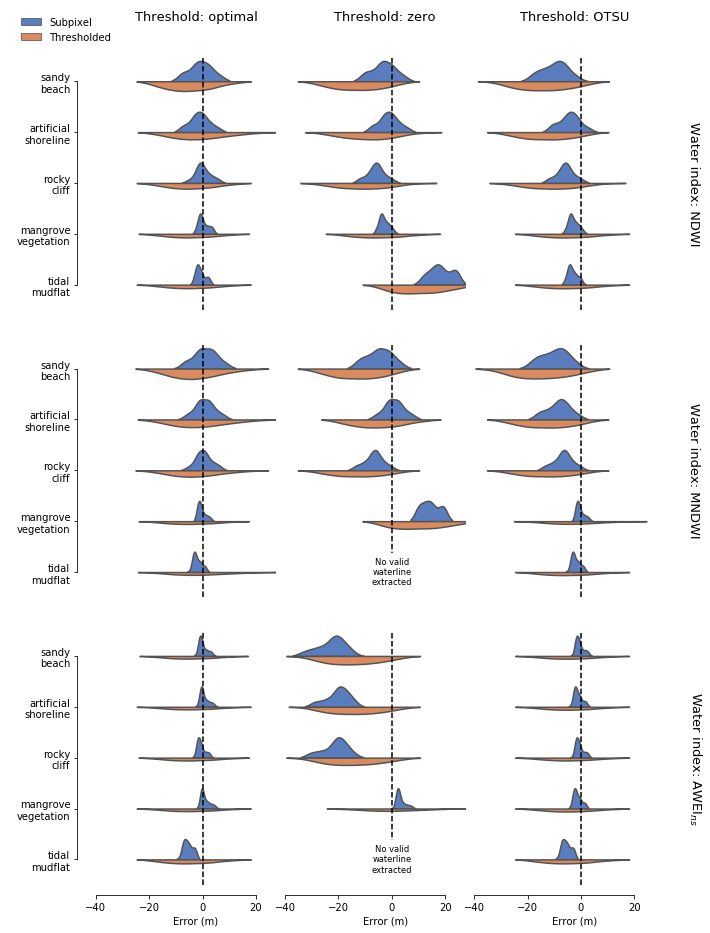

In [70]:
# Identify closest threshold to OTSU for each set of scenarios
accuracy_results['diff_otsu'] = abs(accuracy_results.thresh - accuracy_results.otsu)
is_otsu = (accuracy_results
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['diff_otsu']
           .transform(min) == accuracy_results['diff_otsu'])
accuracy_results_otsu = accuracy_results[is_otsu].copy()
accuracy_results_otsu['thresh'] = 'OTSU\n'

# Identify zero threshold
accuracy_results_zero = accuracy_results[accuracy_results.thresh == 0].copy()
accuracy_results_zero['thresh'] = 'zero\n'

# Identify optimal threshold
accuracy_results['RMSE'] = accuracy_results.groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)'].transform(RMSE)   
is_optimal = (accuracy_results
           .groupby(['spectra', 'resolution', 'water_index', 'type'])['RMSE']
           .transform(min) == accuracy_results['RMSE'])
accuracy_results_optimal = accuracy_results[is_optimal].copy()
accuracy_results_optimal['thresh'] = 'optimal\n'


# Merge all datasets into a single dataframe
accuracy_results_all = pd.concat([accuracy_results_optimal, accuracy_results_zero, accuracy_results_otsu], sort=False)
accuracy_results_all['spectra'] = accuracy_results_all.spectra.str.replace('_', '\n')

# Update AWEI name
accuracy_results_all.loc[accuracy_results_all.water_index=='AWEI_ns', 'water_index'] = 'AWEI$_{ns}$'


#################
# Generate plot #
#################

# Determine nice plotting order for spectra (from lowest to highest mean)
x_order = ['sandy\nbeach', 'artificial\nshoreline', 'rocky\ncliff', 'mangrove\nvegetation', 'tidal\nmudflat']

g = sns.catplot(x="Error (m)", y="spectra", hue='type', data=accuracy_results_all, 
                col='thresh', row='water_index', height=4.2, aspect=0.8, palette="muted", 
                split=True, kind="violin", inner=None, scale='area', bw='silverman', 
                order=x_order, 
                orient='h',
                hue_order=['Subpixel', 'Thresholded'],
                col_order=['optimal\n', 'zero\n', 'OTSU\n'], 
                row_order=['NDWI', 'MNDWI', 'AWEI$_{ns}$'], 
                margin_titles=True, sharey=False, cut=1.5, gridsize=300)




##################
# Customise plot #
##################

# # Set up named axes
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)  = g.axes

# # Bulk add horizontal 0 error line to all plots
[ax.axvline(0, color='black', linestyle='--') for ax in g.axes.flat]

# # Remove axis labels from bottom facets
ax1.set_ylabel('')
ax4.set_ylabel('')
ax7.set_ylabel('')

# # Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = 'Water index: {row_name}', col_template = 'Threshold: {col_name}\n', size=13)

# # Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)

# Remove axes lines and tickes from top facets
sns.despine(ax=ax1, bottom=True)
sns.despine(ax=ax2, left=True, bottom=True)
sns.despine(ax=ax3, left=True, bottom=True)
ax1.tick_params(axis='x', which='both',length=0)
ax2.tick_params(axis='both', which='both',length=0)
ax3.tick_params(axis='both', which='both',length=0)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])

# Remove axes lines and tickes from middle facets
sns.despine(ax=ax4, bottom=True)
sns.despine(ax=ax5, left=True, bottom=True)
sns.despine(ax=ax6, left=True, bottom=True)
ax4.tick_params(axis='x', which='both',length=0)
ax5.tick_params(axis='both', which='both',length=0)
ax6.tick_params(axis='both', which='both',length=0)
ax5.set(yticklabels=[])
ax6.set(yticklabels=[])

# Remove axes lines and tickes from bottom facets
sns.despine(ax=ax8, left=True)
sns.despine(ax=ax9, left=True)
ax8.tick_params(axis='y', which='both',length=0)
ax9.tick_params(axis='y', which='both',length=0)
ax8.set(yticklabels=[])
ax9.set(yticklabels=[])

# # Add extra white space between columns
plt.subplots_adjust(hspace=0.13, wspace=-0.13)

# Make legend have two columns, and move to custom position
handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, ncol=1, loc='upper center', 
                bbox_to_anchor=(0.08, 1.02), frameon=False)

# Add annotation for missing MNDWI data
ax5.text(0, 4.45, "No valid\nwaterline\nextracted\n", horizontalalignment='center', size='small', 
         color='black', bbox=dict(facecolor='white', edgecolor='white', alpha=1.0))
ax8.text(0, 4.45, "No valid\nwaterline\nextracted\n", horizontalalignment='center', size='small', 
         color='black', bbox=dict(facecolor='white', edgecolor='white', alpha=1.0))


## Analyse by resolution

In [27]:
scenarios_df = (accuracy_results
 
                 # Keep only rows with optimal thresholds
                 .loc[is_optimal, ['spectra', 'thresh', 'resolution', 'water_index', 'type']]
                 .drop_duplicates()

                 # Spread into wide format
                 .reset_index(drop=True)
                 .set_index(['spectra', 'resolution', 'water_index', 'type'], append=True) 
                 .unstack('type')

                 # Collapse NA rows by taking max of groups
                 .groupby(['spectra', 'resolution', 'water_index'])
                 .max()

                 # Remove redundant multiindex levels 
                 .xs('thresh', axis=1, drop_level=True)
                 .reset_index()

                 # Rename and reorder columns
                 .rename({'Subpixel': 'thresh_subpixel',
                          'Thresholded': 'thresh_thresholded'}, axis=1) 
                 .iloc[:, [0, 2, 1, 3, 4]])

# Create resolution scenarios
resolution_scenarios = np.arange(5, 31, 5).tolist()  #[2] + 
scenarios_df = scenarios_df.loc[scenarios_df.index.repeat(len(resolution_scenarios))]
scenarios_df['resolution'] = resolution_scenarios * int(scenarios_df.shape[0] / len(resolution_scenarios))
scenarios_df.shape

# Analyse scenarios 
accuracy_results_res = waterline_scenarios(thresh_array, scenarios_df, spectra_scenarios, dist=5)   
accuracy_results_res.head()


Spectra: tidal_mudflat Index: NDWI Resolution: 30 Threshold subpixel: 0.25 Threshold threshholded: 0.2

,spectra,thresh,resolution,water_index,type,Error (m),otsu
0,artificial_shoreline,-0.5,5,AWEI_ns,Subpixel,0.500000,-0.474353
1,artificial_shoreline,-0.5,5,AWEI_ns,Subpixel,0.280384,-0.474353
2,artificial_shoreline,-0.5,5,AWEI_ns,Subpixel,0.622920,-0.474353
3,artificial_shoreline,-0.5,5,AWEI_ns,Subpixel,0.260468,-0.474353
4,artificial_shoreline,-0.5,5,AWEI_ns,Subpixel,0.229726,-0.474353


In [ ]:
# sns.relplot(data=accuracy_results, x='thresh', y='RMSE', hue='spectra', col='type', kind='line', row='water_index', height=3)

### Plot results by resolution

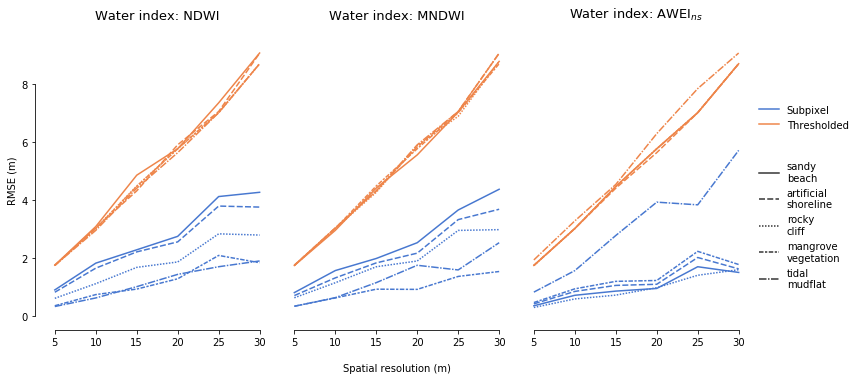

In [28]:
# Update AWEI name
accuracy_results_res.loc[accuracy_results_res.water_index=='AWEI_ns', 'water_index'] = 'AWEI$_{ns}$'


test = pd.DataFrame(accuracy_results_res.groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)'].apply(RMSE)).reset_index()
test['spectra'] = test.spectra.str.replace('_', '\n')
test = test.rename({'resolution': '\nSpatial resolution (m)'}, axis=1)
test = test.rename({'Error (m)': 'RMSE (m)'}, axis=1)

# test = pd.DataFrame(accuracy_results_res.groupby(['spectra', 'thresh', 'resolution', 'water_index', 'type'])['Error (m)'].mean()).reset_index()
# test['spectra'] = test.spectra.str.replace('_', '\n')
# test = test.rename({'resolution': '\nSpatial resolution (m)'}, axis=1)
# test = test.rename({'Error (m)': 'RMSE (m)'}, axis=1)

# Plot data
g = sns.relplot(x="\nSpatial resolution (m)", 
                y="RMSE (m)", 
                hue='type', 
                col='water_index', 
                style='spectra',
                data=test, 
                col_order=['NDWI', 'MNDWI', 'AWEI$_{ns}$'],
                style_order = x_order, 
                height=5.0, 
                aspect=0.7, 
                palette="muted", 
                kind='line')

# Set up named axes
(ax1, ax2, ax3) = g.axes[0]

# Remove axis labels from bottom facets
ax1.set_xlabel('')
ax3.set_xlabel('')

# Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(col_template = 'Water index: {col_name}\n', size=13)

# Remove legend titles
g._legend.texts[0].set_text("")
g._legend.texts[3].set_text("\n")
g._legend.set_title("")

# Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)
sns.despine(ax=ax2, left=True)
sns.despine(ax=ax3, left=True)
ax2.tick_params(axis='y', which='both', length=0)
ax3.tick_params(axis='y', which='both', length=0)


## Import WV2

In [45]:
import glob
import os
import pandas as pd
import xarray as xr
import affine
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

# Import study area
wv2_env_gdf = gpd.GeoDataFrame.from_file('raw_data/wv2_environments.geojson')
wv2_env_gdf = wv2_env_gdf.to_crs({'init' :'EPSG:32755'})

# Get list of files to analysis
filenames = glob.glob('/g/data/u46/users/ia1511/Work/data/worldview-2/outdir/extracted/20300100B4EA4A00/RES-GROUP-0/STANDARDISED-PRODUCTS/REFLECTANCE/NBART/*.tif')

# Import data as a dask array with named bands based on file names
band = xr.Variable('band', [os.path.basename(f)[:-4].replace('-', '_') for f in filenames])
chunks = {'x': 5000, 'y': 5000, 'band': 1}
wv2_ds = xr.concat([xr.open_rasterio(f, chunks=chunks) for f in filenames], dim=band).to_dataset(dim='band')

# Fix nodata
wv2_ds = wv2_ds.where(wv2_ds != -999)

# Add affine
wv2_ds.attrs['transform'] = affine.Affine(*wv2_ds.transform)
wv2_ds.attrs['crs'] = wv2_ds.crs[6:]

# Create land-water array
wv2_ds['land_water'] = ((wv2_ds.BAND_G - wv2_ds.BAND_N)/(wv2_ds.BAND_G + wv2_ds.BAND_N)).compute() > 0
# wv2_ds['land_water'] = ((wv2_ds.BAND_C - wv2_ds.BAND_N2)/(wv2_ds.BAND_C + wv2_ds.BAND_N2)).compute() > 0


In [73]:
import rasterio

def wv2_scenarios(wv2_ds, scenarios_df, spectra_scenarios, dist=10):

    output_dist_list = []

    for i, (spectra, water_index, resolution, thresh_subpixel, thresh_thresholded) in scenarios_df.iterrows():

        print('\rSpectra:', spectra, 'Index:', water_index, 'Aggregation:', resolution, 
              'Threshold subpixel:', np.round(thresh_subpixel, 2), 'Threshold threshholded:', np.round(thresh_thresholded, 2), end='')

        try:    
   

            ####################
            # Model shorelines #
            ####################

            # Generate simulated shoreline based on input threshold and aggregation factor
            output_waterlines = simulated_waterlines(wv2_ds, 
                                                     agg_factor = resolution, 
                                                     thresh_subpixel = thresh_subpixel, 
                                                     thresh_thresholded = thresh_thresholded, 
                                                     water_index=water_index,
                                                     outdir='output_data/wv2/wv2_')
            wv2_ref_gdf, wv2_subpixel_gdf, wv2_wholepixel_gdf, wv2_agg_ds = output_waterlines

            # Compute OTSU on NDWI layer
            selected_env = wv2_env_gdf[wv2_env_gdf.env_type == spectra].unary_union            
            mask = rasterio.features.rasterize([selected_env.__geo_interface__], 
                                               out_shape=(len(wv2_agg_ds.y), len(wv2_agg_ds.x)), 
                                               transform=wv2_agg_ds.transform, all_touched=True)            
            
            wv2_agg_array = wv2_agg_ds.where(mask).water_index.values
            otsu = threshold_otsu(wv2_agg_array[np.isfinite(wv2_agg_array)])
            
            # Compute distances
            subpixel_points, wholepixel_points = dist_stats(ds=wv2_agg_ds, 
                                                            ref_gdf=wv2_ref_gdf, 
                                                            subpixel_gdf=wv2_subpixel_gdf, 
                                                            wholepixel_gdf=wv2_wholepixel_gdf, 
                                                            dist=dist)   
            
            # Get attributes from layers, and clip to current spectra
            subpixel_points.crs = wholepixel_points.crs = wv2_env_gdf.crs
            subpixel_points_env = gpd.sjoin(subpixel_points, wv2_env_gdf, how='left')
            subpixel_points = subpixel_points_env[subpixel_points_env.env_type == spectra]            
            wholepixel_points_env = gpd.sjoin(wholepixel_points, wv2_env_gdf, how='left')
            wholepixel_points = wholepixel_points_env[wholepixel_points_env.env_type == spectra]

            # Append results to list
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_subpixel, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Sub-pixel', 
                                                  'Error (m)': subpixel_points['dist_val'], 'otsu': otsu}))
            output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh_thresholded, 'resolution': resolution, 
                                                  'water_index': water_index, 'type': 'Whole-pixel', 
                                                  'Error (m)': wholepixel_points['dist_val'], 'otsu': otsu}))                                   

        except:
            pass

    # Combine results into a single dataframe
    accuracy_results = pd.concat(output_dist_list)
    
    # Return dataframe
    return accuracy_results


spectra_scenarios = ['rocky_cliff', 'mangrove_veg', 'sandy_beach'] 
index_scenarios = ['NDWI_wv2']  
resolution_scenarios = [15]
thresh_subpixel_scenarios = np.linspace(-0.5, 0.5, 51)

# Create dataframe of all scenarios
all_combinations = itertools.product(spectra_scenarios, index_scenarios, 
                                     resolution_scenarios, thresh_subpixel_scenarios)
scenarios_df = pd.DataFrame(all_combinations, columns=['spectra', 'water_index', 
                                                       'resolution', 'thresh_subpixel'])

# Add new column duplicating subpixel threshold for threshholded analysis
scenarios_df['thresh_thresholded'] = scenarios_df.thresh_subpixel
scenarios_df


,spectra,water_index,resolution,thresh_subpixel,thresh_thresholded
0,rocky_cliff,NDWI_wv2,15,-0.50,-0.50
1,rocky_cliff,NDWI_wv2,15,-0.48,-0.48
2,rocky_cliff,NDWI_wv2,15,-0.46,-0.46
3,rocky_cliff,NDWI_wv2,15,-0.44,-0.44
4,rocky_cliff,NDWI_wv2,15,-0.42,-0.42
5,rocky_cliff,NDWI_wv2,15,-0.40,-0.40
6,rocky_cliff,NDWI_wv2,15,-0.38,-0.38
7,rocky_cliff,NDWI_wv2,15,-0.36,-0.36
8,rocky_cliff,NDWI_wv2,15,-0.34,-0.34
9,rocky_cliff,NDWI_wv2,15,-0.32,-0.32


In [74]:
out = wv2_scenarios(wv2_ds, scenarios_df, spectra_scenarios, dist=5)

Spectra: sandy_beach Index: NDWI_wv2 Aggregation: 15 Threshold subpixel: 0.5 Threshold threshholded: 0.5

In [82]:
out[out.thresh == -0.36].groupby(['spectra', 'type'])['Error (m)'].apply(RMSE)

spectra       type       
mangrove_veg  Sub-pixel       5.102791
              Whole-pixel     8.489395
rocky_cliff   Sub-pixel      11.762145
              Whole-pixel    12.879510
sandy_beach   Sub-pixel      34.717041
              Whole-pixel    36.318941
Name: Error (m), dtype: float64

In [44]:
# agg_factor = 15

# out = simulated_waterlines(wv2_ds, 
#                            agg_factor = agg_factor, 
#                            thresh_subpixel = 0, 
#                            thresh_thresholded = 0, 
#                            water_index='NDWI_wv2',
#                            outdir='output_data/wv2/wv2_')

# wv2_ref_gdf, wv2_subpixel_gdf, wv2_wholepixel_gdf, wv2_agg_ds = out

# # Clip to study area and export to file
# wv2_ref_gdf = wv2_ref_gdf.intersection(wv2_env_gdf.unary_union)
# wv2_ref_gdf.to_file(f'output_data/wv2/wv2_reference.shp')

# # Clip to study area and export to file
# wv2_subpixel_gdf = wv2_subpixel_gdf.intersection(wv2_env_gdf.unary_union)
# wv2_subpixel_gdf.to_file(f'output_data/wv2/wv2_subpixel_agg{agg_factor}.shp')

# # Clip to study area and export to file
# wv2_wholepixel_gdf = wv2_wholepixel_gdf.intersection(wv2_env_gdf.unary_union)
# wv2_wholepixel_gdf.to_file(f'output_data/wv2/wv2_wholepixel_agg{agg_factor}.shp')

# # Export NDWI surface
# # write_geotiff(f'output_data/wv2/wv2_agg{agg_factor}.tif', ds_agg[['water_index']])


### Extract aggregated sub-pixel shoreline

### Environments

In [60]:
# Compute distances
subpixel_points, wholepixel_points = dist_stats(ds=wv2_ds, 
                                                ref_gdf=wv2_ref_gdf, 
                                                subpixel_gdf=wv2_subpixel_gdf, 
                                                wholepixel_gdf=wv2_wholepixel_gdf, 
                                                dist=10)               

# Get attributes from layers
subpixel_points_env = gpd.sjoin(subpixel_points, wv2_env_gdf, how='left')
wholepixel_points_env = gpd.sjoin(wholepixel_points, wv2_env_gdf, how='left')
print(subpixel_points_env.groupby('env_type')['dist_val'].apply(RMSE))
print('\n', wholepixel_points_env.groupby('env_type')['dist_val'].apply(RMSE))


/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:32755'} != {'init': 'EPSG:32755'})
  '(%s != %s)' % (left_df.crs, right_df.crs))
/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'EPSG:32755'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


env_type
cloudy           6.245442
mangrove_veg    13.755843
rocky_cliff      4.247624
sandy_beach      5.662094
Name: dist_val, dtype: float64

 env_type
cloudy           7.556059
mangrove_veg    12.937191
rocky_cliff      7.739088
sandy_beach      9.143452
Name: dist_val, dtype: float64


In [48]:
wv2_ds.land_water

<xarray.DataArray 'land_water' (y: 21352, x: 8515)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])
Coordinates:
  * y        (y) float64 8.268e+06 8.268e+06 8.268e+06 ... 8.226e+06 8.226e+06
  * x        (x) float64 3.224e+05 3.224e+05 3.224e+05 ... 3.394e+05 3.394e+05

In [52]:
wv2_ds.land_water.astype(float)

<xarray.DataArray 'land_water' (y: 21352, x: 8515)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])
Coordinates:
  * y        (y) float64 8.268e+06 8.268e+06 8.268e+06 ... 8.226e+06 8.226e+06
  * x        (x) float64 3.224e+05 3.224e+05 3.224e+05 ... 3.394e+05 3.394e+05